In [14]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import allan_variance
np.random.seed(0)
import pandas as pd
from scipy.spatial.transform import Rotation as R
from calibration import IntrinsicCalibration

In [9]:
def interpolate_df(df_base, df_target, columns):
    df_interp = pd.DataFrame({'t': df_base['t']})
    for col in columns:
        df_interp[col] = np.interp(df_base['t'], df_target['t'], df_target[col])
    return df_interp


IMU1_path = 'dataset/CSL_WLK/magpie2Dataset_1_imu1.csv'
IMU2_path = 'dataset/CSL_WLK/magpie2Dataset_1_imu2.csv'
IMU3_path = 'dataset/CSL_WLK/magpie2Dataset_1_imu3.csv'
IMU4_path = 'dataset/CSL_WLK/magpie2Dataset_1_imu4.csv'
IMU5_path = 'dataset/CSL_WLK/magpie2Dataset_1_imu5.csv'

df1 = pd.read_csv(IMU1_path)
df2 = pd.read_csv(IMU2_path)
df3 = pd.read_csv(IMU3_path)
df4 = pd.read_csv(IMU4_path)
df5 = pd.read_csv(IMU5_path)

columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az']
df2_interp = interpolate_df(df1, df2, columns)
df3_interp = interpolate_df(df1, df3, columns)
df4_interp = interpolate_df(df1, df4, columns)
df5_interp = interpolate_df(df1, df5, columns)
dfs = [df1, df2_interp, df3_interp, df4_interp, df5_interp]
# dfs = [df1, df2, df3, df4, df5]

num_imus = len(dfs)

t_data = {}
gx_data, gy_data, gz_data = {}, {}, {}
ax_data, ay_data, az_data = {}, {}, {}
measurements = []

for i, df in enumerate(dfs, start=1):
    t_data[f'df{i}_t'] = np.array((df['t']-df['t'][0])/1e9)
    gx_data[f'df{i}_gx'] = np.array(df['gx'])
    gy_data[f'df{i}_gy'] = np.array(df['gy'])
    gz_data[f'df{i}_gz'] = np.array(df['gz'])
    ax_data[f'df{i}_ax'] = np.array(df['ax'])
    ay_data[f'df{i}_ay'] = np.array(df['ay'])
    az_data[f'df{i}_az'] = np.array(df['az'])

for i in range(len(df1)):
# for i in range(4000):
    measurements.append([ax_data['df1_ax'][i], ay_data['df1_ay'][i], az_data['df1_az'][i], gx_data['df1_gx'][i], gy_data['df1_gy'][i], gz_data['df1_gz'][i], 
                        ax_data['df2_ax'][i], ay_data['df2_ay'][i], az_data['df2_az'][i], gx_data['df2_gx'][i], gy_data['df2_gy'][i], gz_data['df2_gz'][i],
                        ax_data['df3_ax'][i], ay_data['df3_ay'][i], az_data['df3_az'][i], gx_data['df3_gx'][i], gy_data['df3_gy'][i], gz_data['df3_gz'][i],
                        ax_data['df4_ax'][i], ay_data['df4_ay'][i], az_data['df4_az'][i], gx_data['df4_gx'][i], gy_data['df4_gy'][i], gz_data['df4_gz'][i],
                        ax_data['df5_ax'][i], ay_data['df5_ay'][i], az_data['df5_az'][i], gx_data['df5_gx'][i], gy_data['df5_gy'][i], gz_data['df5_gz'][i]])
    
measurements = np.array(measurements)

dt = np.mean(np.diff(t_data['df1_t']))

In [10]:
def calibrated_measurements(meas, det_params, biases, R_acc, R_gyro): 
    gravity = 9.81
    cal_meas = []
    for i in range(len(meas)):
        all_meas = []
        for j in range(num_imus):
            raw_a = meas[i][j*6:j*6+3]
            raw_g = meas[i][j*6+3:j*6+6]
            b_a = [biases['ax'][f'df{j+1}_ax'], biases['ay'][f'df{j+1}_ay'], biases['az'][f'df{j+1}_az']]
            b_g = [biases['gx'][f'df{j+1}_gx'], biases['gy'][f'df{j+1}_gy'], biases['gz'][f'df{j+1}_gz']]
            SM_a = np.linalg.inv(det_params['acc_M'][f'imu{j+1}'])
            SM_g = np.linalg.inv(det_params['acc_M'][f'imu{j+1}'])
            A = det_params['A'][f'imu{j+1}']
            a_si = raw_a - b_a
            a_si[2] -= gravity
            a_si = np.dot(SM_a, a_si)
            g_si = np.dot(SM_g, (raw_g - b_g - np.dot(A, a_si)))

            new_meas = np.array([a_si, g_si]).flatten()
            all_meas.append(new_meas)
        flattened_meas = np.array(all_meas).flatten()
        cal_meas.append(flattened_meas)
    
    return cal_meas

IMU1_cal = 'dataset/static/magpie2Dataset_StaticData_imu1.csv'
IMU2_cal = 'dataset/static/magpie2Dataset_StaticData_imu2.csv'
IMU3_cal = 'dataset/static/magpie2Dataset_StaticData_imu3.csv'
IMU4_cal = 'dataset/static/magpie2Dataset_StaticData_imu4.csv'
IMU5_cal = 'dataset/static/magpie2Dataset_StaticData_imu5.csv'
IMU_paths = [IMU1_cal, IMU2_cal, IMU3_cal, IMU4_cal, IMU5_cal]
cal_path = 'dataset/static/magpie2Dataset_000-imu.yaml'
cal = IntrinsicCalibration(IMU_paths, cal_path)
cal.get_av_params()
cal.get_bias()
cal.get_det_params()
params = cal.params
biases = cal.biases
det_params = cal.det_params


T01 = np.array(det_params['T_i_b']['imu1'])
T02 = np.array(det_params['T_i_b']['imu2'])
T03 = np.array(det_params['T_i_b']['imu3'])
T04 = np.array(det_params['T_i_b']['imu4'])
T05 = np.array(det_params['T_i_b']['imu5'])

R21 = T02[:3,:3].T.dot(T01[:3,:3])
R31 = T03[:3,:3].T.dot(T01[:3,:3])
R41 = T04[:3,:3].T.dot(T01[:3,:3])
R51 = T05[:3,:3].T.dot(T01[:3,:3])
R_acc = [np.eye(3), R21.T, R31.T, R41.T, R51.T]

P21 = -T02[:3,3] + T01[:3,3]
P31 = -T03[:3,3] + T01[:3,3]
P41 = -T04[:3,3] + T01[:3,3]
P51 = -T05[:3,3] + T01[:3,3]

C01 = np.array(det_params['C_gyro_i']['imu1'])
C02 = np.array(det_params['C_gyro_i']['imu2'])
C03 = np.array(det_params['C_gyro_i']['imu3'])
C04 = np.array(det_params['C_gyro_i']['imu4'])
C05 = np.array(det_params['C_gyro_i']['imu5'])

C21 = C02.T.dot(C01)
C31 = C03.T.dot(C01)
C41 = C04.T.dot(C01)
C51 = C05.T.dot(C01)
R_gyro = [np.eye(3), C21.T, C31.T, C41.T, C51.T]


cal_meas = calibrated_measurements(measurements, det_params, biases, R_acc, R_gyro)
cal_meas = np.array(cal_meas)

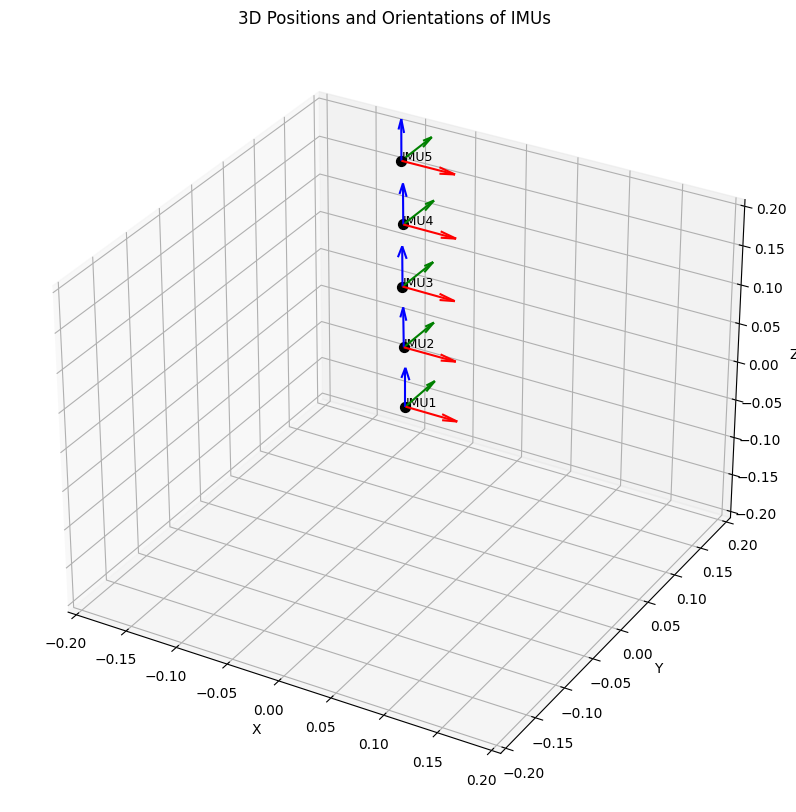

In [11]:
positions = [np.array([0, 0, 0]), -P21, -P31, -P41, -P51]

rotations = [np.eye(3), R21.T, R31.T, R41.T, R51.T]
rotations_gyro = [np.eye(3), C21.T, C31.T, C41.T, C51.T]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
axis_colors = ['r', 'g', 'b']
labels = ['IMU1', 'IMU2', 'IMU3', 'IMU4', 'IMU5']

for i, (pos, rot) in enumerate(zip(positions, rotations_gyro)):
    ax.scatter(pos[0], pos[1], pos[2], color='k', s=50)
    ax.text(pos[0], pos[1], pos[2], labels[i], fontsize=9)
    for j in range(3):
        axis = rot[:, j]
        ax.quiver(pos[0], pos[1], pos[2], axis[0], axis[1], axis[2], length=0.05, color=axis_colors[j])

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.2)
ax.set_title('3D Positions and Orientations of IMUs')

plt.show()

In [12]:
measurements = []

for i in range(len(df1)):
    measurements.append([ax_data['df1_ax'][i], ay_data['df1_ay'][i], az_data['df1_az'][i], gx_data['df1_gx'][i], gy_data['df1_gy'][i], gz_data['df1_gz'][i], 
                        ax_data['df2_ax'][i], ay_data['df2_ay'][i], az_data['df2_az'][i], gx_data['df2_gx'][i], gy_data['df2_gy'][i], gz_data['df2_gz'][i],
                        ax_data['df3_ax'][i], ay_data['df3_ay'][i], az_data['df3_az'][i], gx_data['df3_gx'][i], gy_data['df3_gy'][i], gz_data['df3_gz'][i],
                        ax_data['df4_ax'][i], ay_data['df4_ay'][i], az_data['df4_az'][i], gx_data['df4_gx'][i], gy_data['df4_gy'][i], gz_data['df4_gz'][i],
                        ax_data['df5_ax'][i], ay_data['df5_ay'][i], az_data['df5_az'][i], gx_data['df5_gx'][i], gy_data['df5_gy'][i], gz_data['df5_gz'][i]])

In [5]:
def inv_T(T):
    R = T[0:3, 0:3]
    t = T[0:3, 3]
    R_inv = R.T
    t_inv = -np.dot(R_inv, t)
    T_inv = np.eye(4)
    T_inv[0:3, 0:3] = R_inv
    T_inv[0:3, 3] = t_inv
    
    return T_inv

In [ ]:
def quat2Rot(q):
    return R.from_quat(q).as_matrix()

def exp_q_R(eta, q_old):
    """
    Perform quaternion update with small rotation using the right multiplication method.

    Parameters:
    - eta: Rotation vector (3,)
    - q_old: Previous quaternion (4,)

    Returns:
    - q_new: Updated quaternion (4,)
    """
    eta1, eta2, eta3 = eta

    # Define the Omega matrix
    OMEGA = np.array([
        [0, -eta1, -eta2, -eta3],
        [eta1, 0, eta3, -eta2],
        [eta2, -eta3, 0, eta1],
        [eta3, eta2, -eta1, 0]
    ])

    norm_eta = np.linalg.norm(eta)

    if norm_eta != 0:
        q_new = (np.cos(norm_eta / 2) * np.eye(4) + 
                 (1 / norm_eta) * np.sin(norm_eta / 2) * OMEGA) @ q_old
        q_new = q_new / np.linalg.norm(q_new)
    else:
        q_new = q_old

    return q_new

import numpy as np

def exp_q_L(eta, q_old):
    """
    Perform quaternion update with small rotation using the left multiplication method.

    Parameters:
    - eta: Rotation vector (3,)
    - q_old: Previous quaternion (4,)

    Returns:
    - q_new: Updated quaternion (4,)
    """
    eta1, eta2, eta3 = eta

    # Define the OMEGA matrix
    OMEGA = np.array([
        [0, eta1, eta2, eta3],
        [-eta1, 0, eta3, -eta2],
        [-eta2, -eta3, 0, eta1],
        [-eta3, eta2, -eta1, 0]
    ])

    # Compute the norm of eta
    norm_eta = np.linalg.norm(eta)

    if norm_eta != 0:
        q_new = (np.cos(norm_eta / 2) * np.eye(4) - 
                 (1 / norm_eta) * np.sin(norm_eta / 2) * OMEGA) @ q_old
        q_new = q_new / np.linalg.norm(q_new)
    else:
        q_new = q_old

    return q_new


def EKF_gm(N, T, y_gyr, y_acc, g, q_0, v_0, p_0, R_gyr, R_acc):
    """
    Inputs:
    - N: Number of samples
    - T: Sampling time
    - y_gyr: Gyroscope measurements, shape (3, N)
    - y_acc: Accelerometer measurements, shape (3, N)
    - g: Gravity field, in world frame, shape (3,)
    - q_0: Initial orientation (unit quaternion), shape (4,)
    - v_0: Initial velocity, shape (3,)
    - p_0: Initial position, shape (3,)
    - R_gyr: Variance of gyroscope measurements, shape (3, 3)
    - R_acc: Variance of accelerometer measurement, shape (3, 3)

    Outputs:
    - p_hat: Position estimate, shape (3, N)
    - v_hat: Velocity estimate, shape (3, N)
    - q_hat: Orientation estimate (unit quaternion), shape (4, N)
    """
    # Initialize state estimates
    p_hat = np.zeros((3, N))
    v_hat = np.zeros((3, N))
    q_hat = np.zeros((4, N))
    f_b_hat = np.zeros((3, N))
    acc_hat = np.zeros((3, N))
    
    # Initialize covariance
    P = np.zeros((3, 3, N))
    P[:, :, 0] = 0.0001 * np.eye(3)  # Initial orientation deviation covariance
    
    # Skew-symmetric matrix for gravity
    gx = np.array([[0, -g[2], g[1]],
                   [g[2], 0, -g[0]],
                   [-g[1], g[0], 0]])
    
    # Set initial orientation, velocity, and position
    q_hat[:, 0] = q_0
    v_hat[:, 0] = v_0
    p_hat[:, 0] = p_0

    # EKF loop
    for t in range(1, N):
        
        # Dynamic state update
        f_b_hat[:, t-1] = y_acc[:, t-1]
        acc_hat[:, t-1] = quat2Rot(q_hat[:, t-1]) @ f_b_hat[:, t-1] + g
        v_hat[:, t] = v_hat[:, t-1] + T * acc_hat[:, t-1]
        p_hat[:, t] = p_hat[:, t-1] + T * v_hat[:, t-1]
        q_hat[:, t] = exp_q_R(y_gyr[:, t-1] * T, q_hat[:, t-1])
        
        # Dynamic covariance update
        G_t = T * quat2Rot(q_hat[:, t])
        P[:, :, t] = P[:, :, t-1] + G_t @ R_gyr @ G_t.T
        
        # Acceleration == gravity field assumption
        if abs(np.linalg.norm(y_acc[:, t]) - np.linalg.norm(g)) < 0.05:
            # Measurement state update
            H_t = -(quat2Rot(q_hat[:, t]).T @ gx)
            S_t = H_t @ P[:, :, t] @ H_t.T + R_acc
            K_t = P[:, :, t] @ H_t.T @ np.linalg.inv(S_t)
            eps_t = y_acc[:, t] + quat2Rot(q_hat[:, t]).T @ g
            eta = K_t @ eps_t
            q_hat[:, t] = exp_q_L(eta, q_hat[:, t])
            
            # Measurement covariance update
            P[:, :, t] = P[:, :, t] - K_t @ S_t @ K_t.T
        
        # Measurement covariance update
        P[:, :, t] = P[:, :, t] - K_t @ S_t @ K_t.T
    
    return p_hat, v_hat, q_hat


In [ ]:
# Noise parameters of virtual IMU
WN_av_x = 0.000545870920697456
WN_av_y = 0.000732408947905144
WN_av_z = 0.00027247747862729825
WN_wv_x = 2.342356204510843e-05
WN_wv_y = 2.322497487530326e-05
WN_wv_z = 1.9223825688587986e-05
RW_av_x = 2.5418984352868408e-05
RW_av_y = 1.3390504662724877e-05
RW_av_z = 0.0
RW_wv_x = 0.0
RW_wv_y = 0.0
RW_wv_z = 5.887466774039067e-07

Text(0, 0.5, '$\\hat{\\omega}$ ($^{o}/s$)')

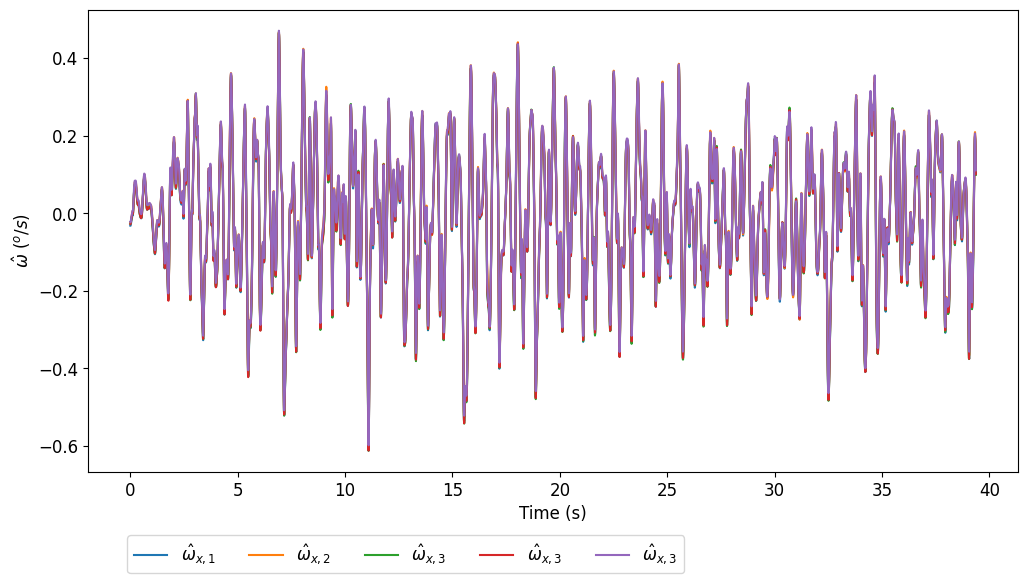

In [13]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(t_data['df1_t'], gx_data['df1_gx'], label = "$\hat{\omega}_{x,1}$")
ax1.plot(t_data['df2_t'], gx_data['df2_gx'], label = "$\hat{\omega}_{x,2}$")
ax1.plot(t_data['df3_t'], gx_data['df3_gx'], label = "$\hat{\omega}_{x,3}$")
ax1.plot(t_data['df4_t'], gx_data['df4_gx'], label = "$\hat{\omega}_{x,3}$")
ax1.plot(t_data['df5_t'], gx_data['df5_gx'], label = "$\hat{\omega}_{x,3}$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=5, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ ($^{o}/s$)", fontsize=12)

Text(0, 0.5, '$\\hat{\\omega}$ ($^{o}/s$)')

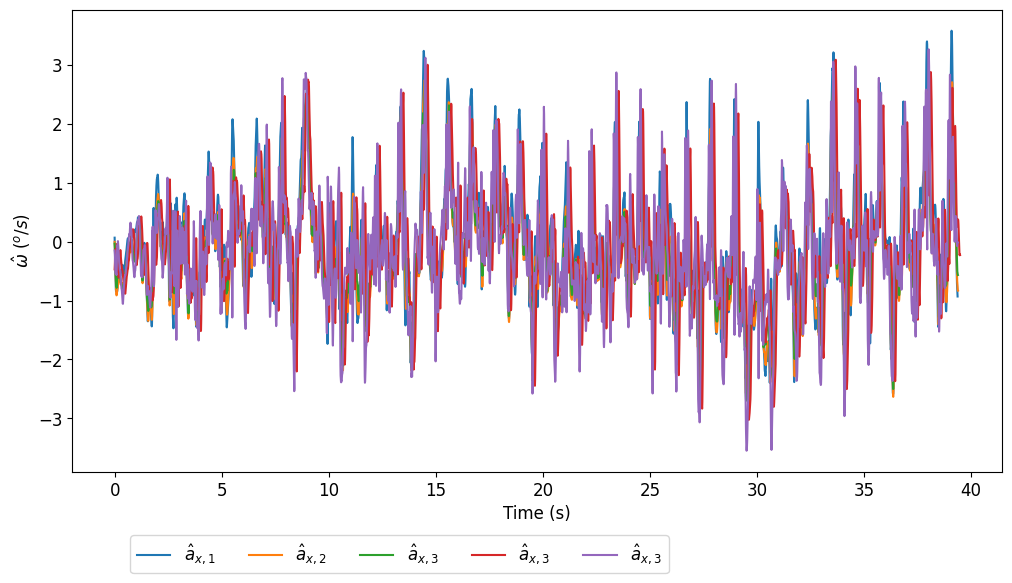

In [13]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(t_data['df1_t'], ax_data['df1_ax'], label = "$\hat{a}_{x,1}$")
ax1.plot(t_data['df2_t'], ax_data['df2_ax'], label = "$\hat{a}_{x,2}$")
ax1.plot(t_data['df3_t'], ax_data['df3_ax'], label = "$\hat{a}_{x,3}$")
ax1.plot(t_data['df4_t'], ax_data['df4_ax'], label = "$\hat{a}_{x,3}$")
ax1.plot(t_data['df5_t'], ax_data['df5_ax'], label = "$\hat{a}_{x,3}$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=5, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ ($^{o}/s$)", fontsize=12)

Text(0, 0.5, '$\\hat{\\omega}$ ($^{o}/s$)')

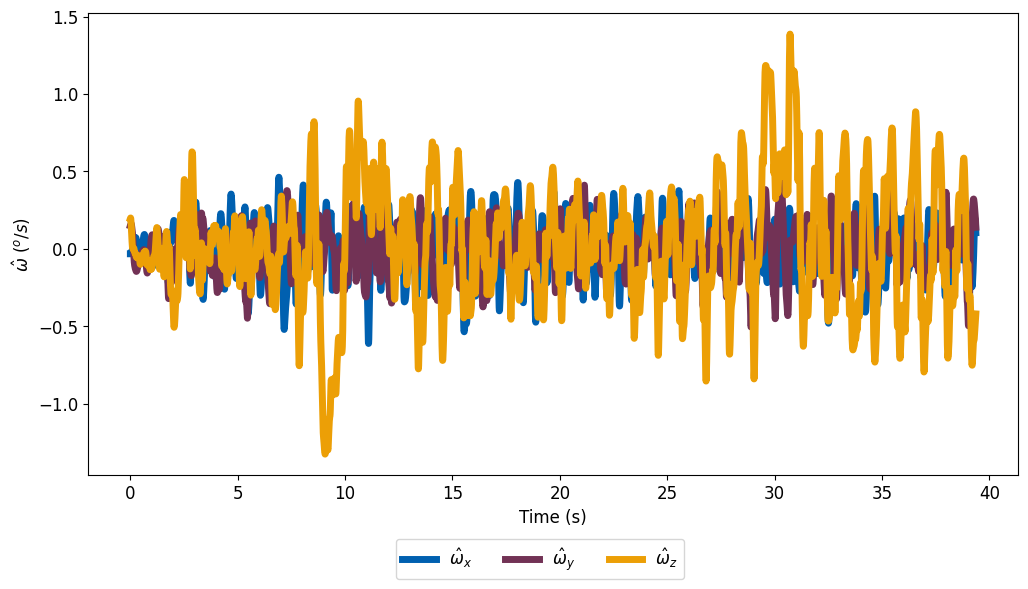

In [7]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(t_data['df1_t'], gx_data['df1_gx'], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax1.plot(t_data['df1_t'], gy_data['df1_gy'], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax1.plot(t_data['df1_t'], gz_data['df1_gz'], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ ($^{o}/s$)", fontsize=12)

Text(0, 0.5, '$\\hat{a}$ ($m/s^2$)')

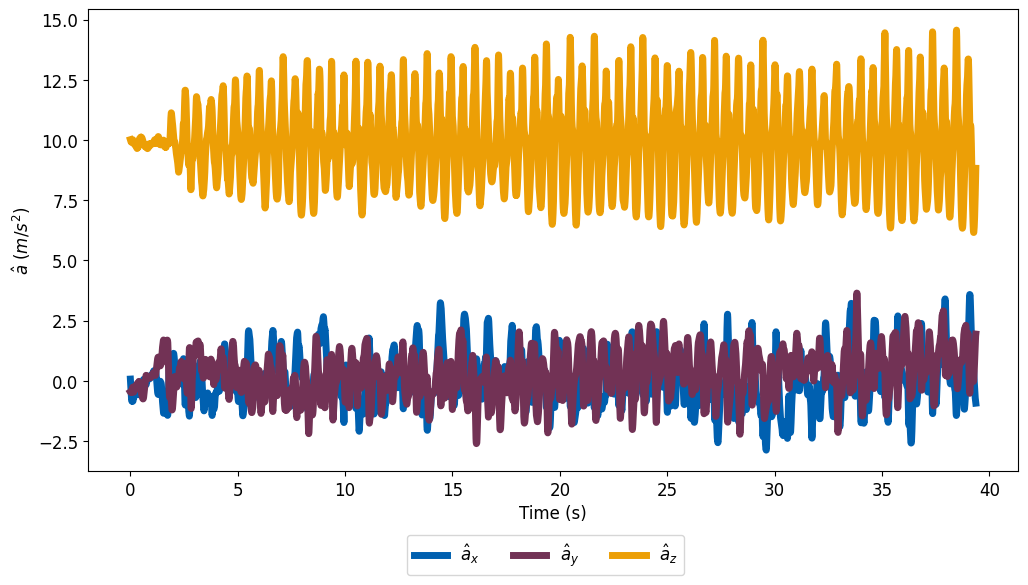

In [9]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(t_data['df1_t'], ax_data['df1_ax'], linewidth=5, color = "#0060B0", label = "$\hat{a}_x$")
ax1.plot(t_data['df1_t'], ay_data['df1_ay'], linewidth=5, color = "#723255", label = "$\hat{a}_y$")
ax1.plot(t_data['df1_t'], az_data['df1_az'], linewidth=5, color = "#EC9F06", label = "$\hat{a}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{a}$ ($m/s^2$)", fontsize=12)